In [1]:
import sys, os, time, glob
import numpy as np
from datetime import datetime
from statistics import median
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import csv
from csv import writer
from csv import reader
import pandas as pd 

In [2]:

dir_name = '/lcrc/project/EE-ECP/jkoo/code/sdv/Benchmarks/'
kernel_dir = '3mm_void'
kernel = '3mm'
kernel_dir = 'covariance_void'
kernel = 'covariance'
# kernel_dir = 'heat-3d_void'
# kernel = 'heat-3d'
# kernel_dir = 'floyd-warshall_void'
# kernel = 'floyd-warshall'
# kernel_dir = 'lu_void'
# kernel = 'lu'
# kernel_dir = 'syr2k_void'
# kernel = 'syr2k'

d_sizes = ['s','sm','m','ml','l','xl']
o3p = {}
for s in d_sizes: 
    time = pd.read_csv(f'{dir_name}{kernel}_exp/{kernel_dir}/results_{s}_{kernel}_void.csv')['objective']
    o3p[s] = float(time)

o3p

{'s': 0.000732,
 'sm': 0.0051485,
 'm': 0.016036,
 'ml': 0.460138,
 'l': 2.157349,
 'xl': 21.8962815}

In [3]:
#### RF rerun 
dir_name = '/lcrc/project/EE-ECP/jkoo/code/ytopt/ytopt/benchmark/polybench-exp'
dir_name_gptune = '/lcrc/project/EE-ECP/jkoo/code/gptune/examples'
N_infer = 30 # len(200)
n = N_infer
# plot something

d_sizes = ['sm','ml','xl']
gathered = []
cutoffs = []

gathered = [] 
cutoffs = [] 
tag1 = ''#_1.96_gp'# '_1.96_lcb'# 
tag2 = '' # '_19.6_lcb'#_1.96_gp_n30'# '_11.0_lcb' # 
tag3 = ''
tag4 = ''#_1.96_gp'# '_1.96_lcb'# 
tag5 = '_init'#_1.96_gp_n30'# '_11.0_lcb' # 

for d_size, o3 in zip(d_sizes, o3p):    

    alpha = 0.1
    t = 0
    evals = []    
    
    ### BO
    file_n = f'{dir_name}/{kernel}/results_rf_{d_size}_{kernel}{tag1}.csv'
    evals_bo = o3p[d_size] / np.array(pd.read_csv(file_n)['objective']) 
    T_bo  = np.array(pd.read_csv(file_n)['elapsed_sec'])
    evals.extend(evals_bo)
    counter_bo = 0 
    plot_bo = [0]
    best_bo = 0.
    idx_bo = 0
    t_bo = T_bo[idx_bo] 

    ## RS 
    file_n = f'{dir_name}/{kernel}/results_rs_{d_size}_{kernel}{tag1}.csv'
    evals_rs = o3p[d_size] / np.array(pd.read_csv(file_n)['objective']) 
    T_rs  = np.array(pd.read_csv(file_n)['elapsed_sec'])
    evals.extend(evals_rs)
    counter_rs = 0
    plot_rs = [0]
    best_rs = 0. 
    idx_rs = 0
    t_rs = T_rs[idx_rs]
        
    ## GPTUNE 
    file_n = f'{dir_name_gptune}/{kernel}_exp/{kernel}_gptune_dtla/TLA_experiments/SLA-GPTune-{d_size}-tl{tag5}/results.csv'
    evals_dtla = o3p[d_size] / np.array(pd.read_csv(file_n)['objective']) 
#     print (evals_dtla)
    T_dtla  = np.array(pd.read_csv(file_n)['elapsed_sec'])    
    evals.extend(evals_dtla)
    counter_dtla = 0
    plot_dtla = [0]
    best_dtla = 0.
    idx_dtla = 0
    t_dtla = T_dtla[idx_dtla]
    
    ## SDV
    file_n = f'{dir_name}/{kernel}/results_sdv_{d_size}_{kernel}{tag1}.csv'
    evals_sdv = o3p[d_size] / np.array(pd.read_csv(file_n)['exe_time']) 
    T_sdv = np.array(pd.read_csv(file_n)['elapsed_sec'])  
    evals.extend(evals_sdv)
    counter_sdv = 0 
    plot_sdv = [0] 
    best_sdv = 0.
    idx_sdv = 0         
    try:
        t_sdv = T_sdv[idx_sdv]
    except IndexError:
        t_sdv = 0
        
    ## SDV refit
    file_n = f'{dir_name}/{kernel}/results_sdv_{d_size}_{kernel}{tag1}_refit.csv'
    evals_sdv_refit = o3p[d_size] / np.array(pd.read_csv(file_n)['exe_time']) 
    T_sdv_refit = np.array(pd.read_csv(file_n)['elapsed_sec'])  
    evals.extend(evals_sdv_refit)
    counter_sdv_refit = 0 
    plot_sdv_refit = [0] 
    best_sdv_refit = 0.
    idx_sdv_refit = 0       
    try:
        t_sdv_refit = T_sdv_refit[idx_sdv_refit]
    except IndexError:
        t_sdv_refit = 0

    ## BOOTSTRAP
    file_n = f'{dir_name}/{kernel}/results_sdv_{d_size}_{kernel}{tag3}_bootstrap.csv'
    evals_sdv_bootstrap = o3p[d_size] / np.array(pd.read_csv(file_n)['objective']) 
    T_sdv_bootstrap = np.array(pd.read_csv(file_n)['elapsed_sec'])  
    evals.extend(evals_sdv_bootstrap)
    counter_sdv_bootstrap = 0 
    plot_sdv_bootstrap = [0] 
    best_sdv_bootstrap = 0.
    idx_sdv_bootstrap = 0       
    try:
        t_sdv_bootstrap = T_sdv_bootstrap[idx_sdv_bootstrap]
    except IndexError:
        t_sdv_bootstrap = 0         
        
        
    cutoff = sorted(evals, reverse=True)[int(len(evals)*alpha)]#[0]
    print ('cutoff', cutoff)    
        
#     T_max = int(max(T_bo.max(), T_rs.max(), T_dtla.max(), T_sdv.max(), T_sdv_itr.max()))     
    T_max = int(max(T_bo.max(), T_rs.max(), T_sdv_bootstrap.max()))#, T_sdv.max())) 
    
    while t < T_max:  
        # bo
        try:
            if t_bo < t and idx_bo <= 29:
                bo_tmp = evals_bo[idx_bo]
                if not str(bo_tmp) == 'nan':
                    if bo_tmp > cutoff:
                        counter_bo += 1 
                    plot_bo.append(counter_bo)            
                idx_bo += 1 
                if idx_bo <= 29:
                    t_bo = T_bo[idx_bo]
            elif idx_bo == 30:
                pass
    #             plot_bo.append(-1)
            else:
                plot_bo.append(counter_bo)
        except IndexError:
            pass
        
        # rs  
        try:
            if t_rs < t and idx_rs <= 29: 
                rs_tmp = evals_rs[idx_rs]
                if not str(rs_tmp) == 'nan':        
                    if rs_tmp > cutoff:
                        counter_rs += 1 
                    plot_rs.append(counter_rs)
                idx_rs += 1 
                if idx_rs <= 29:
                    t_rs = T_rs[idx_rs]
            elif idx_rs == 30:
                pass
    #             plot_rs.append(-1)
            else:
                plot_rs.append(counter_rs)
        except IndexError:
            pass
        
          # dtla
        try:
            if t_dtla < t and idx_dtla <= 29:
                dtla_tmp_itr = evals_dtla[idx_dtla]
                if not str(dtla_tmp_itr) == 'nan': 
                    if dtla_tmp_itr > cutoff:
                        counter_dtla += 1 
                    plot_dtla.append(counter_dtla)
                idx_dtla += 1 
                if idx_dtla <= 29:
                    t_dtla = T_dtla[idx_dtla] 
            elif idx_dtla == 30:
                pass
    #             plot_sdv.append(-1)
            else:
                plot_dtla.append(counter_dtla)              
        except IndexError:
            pass            
        # sdv 
        try:
            if t_sdv < t and idx_sdv <= 29:
                sdv_tmp = evals_sdv[idx_sdv]
                if not str(sdv_tmp) == 'nan': 
                    if sdv_tmp > cutoff:
                        counter_sdv += 1 
                    plot_sdv.append(counter_sdv)
                idx_sdv += 1 
                if idx_sdv <= 29:
                    t_sdv = T_sdv[idx_sdv] 
            elif idx_sdv == 30:
                pass
    #             plot_sdv.append(-1)
            else:
                plot_sdv.append(counter_sdv)
        except IndexError:
            pass                       

        # sdv refit
        try:
            if t_sdv_refit < t and idx_sdv_refit <= 29:
                sdv_tmp_refit = evals_sdv_refit[idx_sdv_refit]
                if not str(sdv_tmp_refit) == 'nan': 
                    if sdv_tmp_refit > cutoff:
                        counter_sdv_refit += 1 
                    plot_sdv_refit.append(counter_sdv_refit)
                idx_sdv_refit += 1 
                if idx_sdv_refit <= 29:
                    t_sdv_refit = T_sdv_refit[idx_sdv_refit] 
            elif idx_sdv_refit == 30:
                pass
    #             plot_sdv.append(-1)
            else:
                plot_sdv_refit.append(counter_sdv_refit)
        except IndexError:
            pass

        # sdv bootstrap
        try:
            if t_sdv_bootstrap < t and idx_sdv_bootstrap <= 29:
                sdv_tmp_bootstrap = evals_sdv_bootstrap[idx_sdv_bootstrap]
                if not str(sdv_tmp_bootstrap) == 'nan': 
                    if sdv_tmp_bootstrap > cutoff:
                        counter_sdv_bootstrap += 1 
                    plot_sdv_bootstrap.append(counter_sdv_bootstrap)
                idx_sdv_bootstrap += 1 
                if idx_sdv_bootstrap <= 29:
                    t_sdv_bootstrap = T_sdv_bootstrap[idx_sdv_bootstrap] 
            elif idx_sdv_bootstrap == 30:
                pass
    #             plot_sdv.append(-1)
            else:
                plot_sdv_bootstrap.append(counter_sdv_bootstrap)
        except IndexError:
            pass        
              
        t += 1

    cc = {}
    cc['bo'] = plot_bo 
    cc['rs'] = plot_rs 
    cc['dtla'] = plot_dtla
    cc['sdv'] = plot_sdv 
    cc['sdv_refit'] = plot_sdv_refit
    cc['sdv_bootstrap'] = plot_sdv_bootstrap

    gathered.append(cc)
    cutoffs.append(cutoff)

cutoff 13.235218508997429
cutoff 2.2655178356022745
cutoff 13.777597785645836


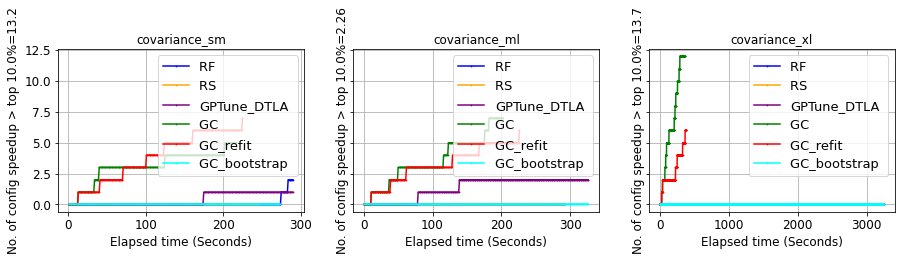

In [4]:
fig, axs = plt.subplots(1,3, figsize=(15, 3), sharex=False, sharey=True)
for ax, cc, d_size, cutoff in zip(axs.flat,gathered,d_sizes,cutoffs):
    dict_s = cc
    #     dict_s['-O3 Polly'] = [0] *1000
    for k, v in dict_s.items():
        if k == 'bo':
            k = 'RF ' + tag1 
#             k = 'RF lcb 1.96 n1'
            color = 'blue'
        if k == 'rs':
            k = 'RS ' + tag2 
#             k = 'RF lcb 11.0 n1'
            color = 'orange'
        if k == 'sdv':
            k = 'GC ' + tag3
            color = 'green'
        if len(v) ==2:
            k = ""
            color = 'white'
        if k == 'sdv_refit':
            k = 'GC_refit ' + tag4
            color = 'red'
        if k == 'sdv_bootstrap':
            k = 'GC_bootstrap ' + tag4
            color = 'Cyan'
        if k == 'dtla':
            k = 'GPTune_DTLA'
            color = 'purple'
        if len(v) ==2:
            k = ""
            color = 'white'
        ax.plot(range(1, len(v) + 1), v, '.-', label=k,linewidth=1.5,markersize=1.5,color=color)
        # NOTE: changed `range(1, 4)` to mach actual values count
    ax.legend(fontsize=13)#,loc='center right')  # To draw legend
    #     plt.title(k_name[:-1],fontsize=14)
    # plt.xlim(0,max_exp+10)
    #     plt.ylim(bottom=0.5)
    ax.set_ylabel('No. of config speedup > top '+str(alpha*100)+'%''='+str(cutoff)[:4], fontsize=12)
    ax.set_xlabel('Elapsed time (Seconds)', fontsize=12)
    ax.set_title(kernel+'_'+d_size,fontsize=12)
    ax.tick_params(axis="x", labelsize=12) 
    ax.tick_params(axis="y", labelsize=12) 
#     ax.set_xticklabels(fontsize=14)
#     ax.set_yticklabels(fontsize=14)
    ax.grid()
#     plt.show()

In [ ]:
gathered[0]['sdv'][-10:]

In [ ]:
gathered[0]['sdv_refit'][-10:]

In [ ]:
gathered[0]['sdv_bootstrap'][-10:]

In [ ]:
gathered[0]['dtla'][-10:]

In [ ]:
        sv = {}
        sv['I']=1
        sv['V']=5
        sv['X']=10
        sv['L']=50
        sv['C']=100
        sv['D']=500
        sv['M']=1000
        sv['IV']=4
        sv['IX']=9
        sv['XL']=40
        sv['XC']=90
        sv['CD']=400
        sv['CM']=900